# Modeling Growth of a Recently Nucleated Bubble in PPG 2700

In this notebook, I predict the nucleation time of a bubble that was observed to grow within the field of view inside an inner stream of PPG 2700 + CO2 using the new Photron NOVA S6. 

Here, I remove one of the possible causes for the discrepancy by using an inner stream of PPG 2700 (3k2f), for which I have diffusivity data from G-ADSA performed at the University of Naples in 2019. The video analyzed is `ppg_co2_50000_000-7_050_0302_90_20_78.mp4`, recorded on July 20, 2021 with a Photron NOVA S6 camera in an observation capillary of ID 300 um.

The saturation pressure was about **70 bar**.

To run this code, first determine the following parameters of your experiment:

1. The viscosity of the fluid used in the outer stream $\eta_o$ in Pa.s. This fluid is a pure polyol, so its viscosity should be measured precisely with a rheometer (e.g., ARES). If the fluid is VORANOL 360 (1k5f), its viscosity at 24.5 C is 4.815 Pa.s (see `REFERENCES/Materials/viscosity/`).
2. Velocity of the inner stream [m/s]. This should be measured by tracking bubbles in the inner stream, either with image processing or manually.
3. Radius of the inner stream $R_i$ [m]. This should be measured by evaluating the width of the inner stream with image processing or manually (by eye and measuring pixel values, converting to meters with calibration slide) and divided by 2 (to convert from diameter to radius).
4. The inner stream viscosity $\eta_i$ in Pa.s The inner stream will likely have additives (CO2, cyclopentane, etc.), so its viscosity will be challenging to measure directly. Instead, estimate it indirectly using the velocity of the inner stream, pressure in the ISCO pumps, and width of the inner stream. Code to make this estimation is written up in `ANALYSIS/flow/20210720_70bar_ppg_co2.ipynb`.
5. Length $l_{tube,o}$ and inner radius $r_{tube,o}$ of the tubing between the outer stream ISCO pump (ISCO 260 D) and the microfluidic device. Values are usually 0.34 m and $472 \times 10^{-6}$m, respectively.
6. Length of the observation capillary (typically 0.1 m).
7. Inner radius of observation capillary $R_o$ in meters.
8. Inner and outer stream flow rates, $Q_i$ and $Q_o$, which should be read during the experiment from the ISCO pumps.
9. Saturation pressure of Parr reactor where inner stream was prepared [Pa]. This should be read from calibrated pressure transducer's LED readout before the first transfer of the fluid to the ISCO 100 DM syringe pump.
10. Polyol solubility values at different pressures. This can be predicted by PC-SAFT after fitting $N$, $\epsilon$, $k_{ij}$, and $\sigma$ to solubility and specific volume data at different temperatures (measured with G-ADSA at Di Maio lab at the U Naples). Once parameters have been fit, predictions can be made under different conditions. See `ppg2700_binary.nb`, which was used to make predictions to fill in `blkrho.inp` in `dft_string_method/bi_surf/` on Wang group server (read `README.txt` in that same folder on the Wang group server for more details).

In [14]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src/')
sys.path.append('../libs/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import polyco2
import bubbleflow
import analytics as an
import diffn
import bubble
import flow
import plot.bubble as pltb
import plot.genl as pltg
import plot.diffn as pltd

# CONVERSIONS
from conversions import *
# CONSTANTS
from constants import *

from importlib import reload
reload(bubbleflow)

# viscosity of inner and outer streams [Pa.s]
eta_i = 0.025 # see flow/20210720_70bar_ppg_co2.ipynb for estimation
eta_o = 4.815
l_tube_o = 0.34 # length of tube for outer stream [m]
r_tube_o = 472E-6 # internal radius of tube for outer stream, approx [m]
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
# inner stream flow rate [uL/min]
Q_i = 50*uLmin_2_m3s
# outer stream flow rate, input to ISCO 260 D [uL/min]
Q_o = 302*uLmin_2_m3s 
# saturation pressure [Pa]
p_s = 80E5
# measured values 
v = 0.74 # center stream velocity [m/s] based on "Dimenions > Manual Tracking" option on PFV4, 
# bubble moves ~13 pixels per frame
# at 60,000 fps and 1.09 pix per um, that's 13 / 1.09 * 60,000 * 1E-6 = 0.716 m/s
d = 0.090 # distance down observation capillary [m]
R_i = 20E-6 # [m] inner stream width measured to be 36 - 39 pixels with PFV4; at 10x obj, 1.09 pix/um -> d = 36 um, R = 18 um
# diffusion model parameters 
dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration
# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = 'input/3k2f_31c.csv' # make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
# equation of state data
eos_co2_file = 'input/eos_co2_22-0C.csv'
# pressure in ISCO 260 D -- see p. 42 entry for video 8.8
p_260d = 1757*psi_2_Pa

# bubble growth model parameters
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]
# 3E-9 # initial bubble radius, estimated around prediction in slide 13 of 20200305_aps_march_meeting [m]

# frame rate [fps]
fps = 50000


### CHOOSE BUBBLE ###
i_bubble = 24


# loads radius from data (image-processing estimate)
import pickle as pkl
with open('input/ppg_co2_50000_000-7_050_0302_90_20_78/test1/data/f_0_1_34932_dist.pkl', 'rb') as f:
    data = pkl.load(f)
bub = data['objects'][i_bubble]
idx_valid = np.logical_not(bub['props_raw']['on border'])
R_bubbles = np.asarray(bub['props_proc']['radius [um]'])[idx_valid] * um_2_m * 2.2/2.6
f_bubbles = np.asarray(bub['props_raw']['frame'])[idx_valid]
v = bub['props_proc']['average speed [m/s]']
d = data['metadata']['object_kwargs']['d']
fps = data['metadata']['fps']

t_bubble = d / v # time bubble had traveled down channel [s]

# additional bubbles
t_bubbles = np.asarray([t_bubble + (f - f_bubbles[0])/fps for f in f_bubbles])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Flow Parameters

In [15]:
# estimates pressure drop down observation capillary from ISCO 260 D [Pa]
p_in = p_260d - flow.p_pois(eta_o, l_tube_o, r_tube_o, Q_o)
# collects relevant parameters
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

# estimates pressure on left and right of field of view
p_left = p_in - (p_in - P_ATM)/L*(d-0.001)
p_center = p_in - (p_in - P_ATM)/L*d
p_right = p_in - (p_in - P_ATM)/L*(d+0.001)
p_nucl = p_in - (p_in - P_ATM)/L*(v*42.7625E-3)

# computes density of pure CO2 at pressure on left and right of field of view
f_rho_co2 = polyco2.interp_rho_co2(eos_co2_file)
rho_co2_left = f_rho_co2(p_left)
rho_co2_right = f_rho_co2(p_right)

print('p_in', p_in)
print('t_bubble', t_bubble)
print('p_left', p_left)
print('p_center', p_center)
print('p_nucl', p_nucl)
print('p_right', p_right)
print('rho_co2_left', rho_co2_left)
print('rho_co2_right', rho_co2_right)
print('R_bubbles', R_bubbles*m_2_um)

p_in 11694472.490135537
t_bubble 0.13119584869584333
p_left 1376548.97391491
p_center 1260617.2490135543
p_nucl 8293619.954146607
p_right 1144685.5241121985
rho_co2_left 26.676774564930646
rho_co2_right 21.87200210514469
R_bubbles [ 2.62190367  3.57234052  4.27511177  4.94078088  5.40371214  5.92973989
  6.35387765  6.80639479  7.23501431  7.65063929  8.07383891  8.60681475
  8.9844594   9.36967245  9.7761343  10.26677965 10.64848909 11.08505982
 11.45396158 11.91080897]


### Epstein-Plesset Model

TODO: edit with parameters of Epstein-Plesset model to fit to growth and identify appropriate diffusivity

In [16]:
def plot_pred_ep_fixed_D(L, eps_params, D, t_nuc_lo, t_nuc_hi, 
                         x_lim_log=[5E-8, 25], y_lim_log=[1E-3, 300],
                         x_lim=[0.0, 5], y_lim=[1, 50], non_sph_frac=0.5,
                         i_t_nuc=0, growth_fn=bubble.grow, i_t=0, i_R=8, 
                         sigma_R=0.01, max_iter=25):
    """
    i_t = 0 # index of t_bub in output of growth_fn
    i_R = 8 # index of R in output of growth_fn
    sigma_R = 0.01 # tolerance of error in radius
    """
    # extracts Epstein--Plesset parameters
    dt, p_s, R_nuc, _, p_in, v, polyol_data_file, eos_co2_file = eps_params
    eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

    # arguments for bubble growth model
    dict_args = {'D' : D}

    # opens figure to show results of different guesses for bubble nucleation time
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # uses modified shooting method to estimate the nucleation time
    t_nuc, output = an.fit_growth_to_pt(t_bubble, R_bubbles[0], t_nuc_lo, t_nuc_hi, growth_fn, list(eps_params),
                         i_t_nuc, sigma_R=sigma_R, ax=ax, max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args)

    # unpacks output
    t, m, D, p, p_bub, if_tension, c_s, c_bulk, R, rho_co2 = output

    # groups results for plotting
    props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)

    # plots properties on log axis
    ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=True, x_lim=x_lim_log, y_lim=y_lim_log, title='')
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t, props_list_fit[0]),
                          non_sph_R=non_sph_frac*R_i)
    ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_bulk)
    pltg.legend(ax)

    # linear time axis
    ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=False, x_lim=x_lim_lin, y_lim=y_lim_lin, title='')
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_s[0])
    pltg.legend(ax)

    return t, t_nuc, props_list_fit, t_bubbles, R_bubbles, R_i, R_o, v, c_bulk

t_nuc = 131.196 ms and error in R is 0.9989.
t_nuc = 130.540 ms and error in R is 4.1009.
t_nuc = 130.868 ms and error in R is 2.6816.
t_nuc = 131.032 ms and error in R is 1.5927.
t_nuc = 131.114 ms and error in R is 0.8121.
t_nuc = 131.155 ms and error in R is 0.2968.
t_nuc = 131.175 ms and error in R is 0.0978.
t_nuc = 131.165 ms and error in R is 0.1267.
t_nuc = 131.170 ms and error in R is 0.0116.
t_nuc = 131.173 ms and error in R is 0.0520.
t_nuc = 131.172 ms and error in R is 0.0149.
t_nuc = 131.171 ms and error in R is 0.0148.
t_nuc = 131.171 ms and error in R is 0.0116.
t_nuc = 131.171 ms and error in R is 0.0115.
t_nuc = 131.171 ms and error in R is 0.0149.
t_nuc = 131.171 ms and error in R is 0.0149.
t_nuc = 131.171 ms and error in R is 0.0149.
t_nuc = 131.171 ms and error in R is 0.0116.
t_nuc = 131.171 ms and error in R is 0.0116.
t_nuc = 131.171 ms and error in R is 0.0149.
t_nuc = 131.171 ms and error in R is 0.0116.
t_nuc = 131.171 ms and error in R is 0.0149.
t_nuc = 13

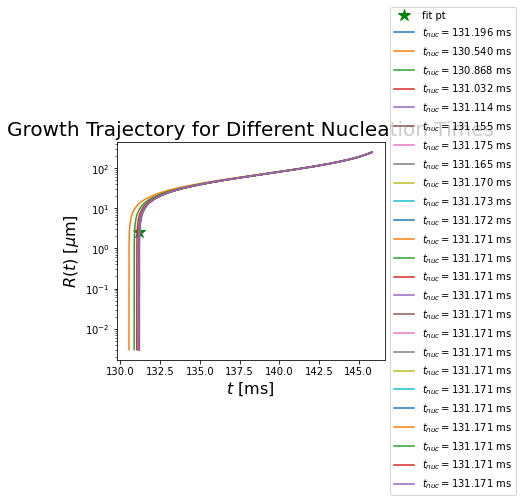

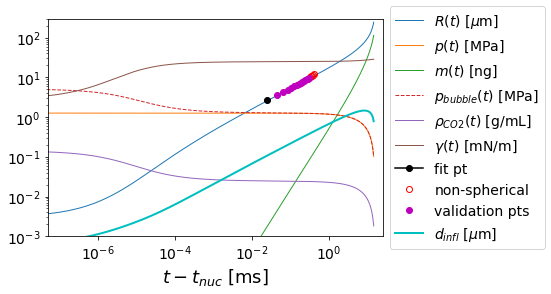

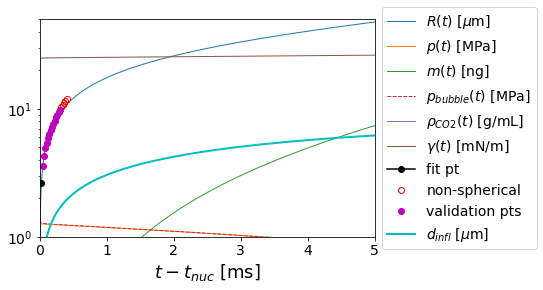

In [17]:
# set parameters
D = 4E-9 # [m^2/s]
L = 0.1 # [m]
# bounds on nucleation time
t_nuc_lo = d/v * 0.99 # [s]
t_nuc_hi = d/v * 1.01 # [s]

# predict nucleation time with Epstein--Plesset
t, t_nuc, props_list_fit, \
t_bubbles, R_bubbles, R_i, \
R_o, v, c_bulk = plot_pred_ep_fixed_D(L, eps_params, D, t_nuc_lo, t_nuc_hi)

#### Plot Results

Model prediction at fit point is R = 2.583016 um.


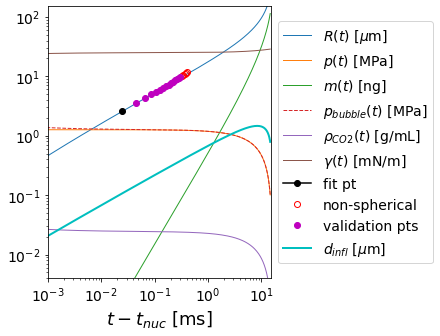

In [5]:
reload(pltb)
# log time axis
x_lim = [1E-3, 1.5E1]
y_lim = [0.004, 150]
x_log = True
fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(111)
ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t, props_list_fit[0]),
                  non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)


#### Austere Plot for ICTAM Poster

Model prediction at fit point is R = 2.583016 um.


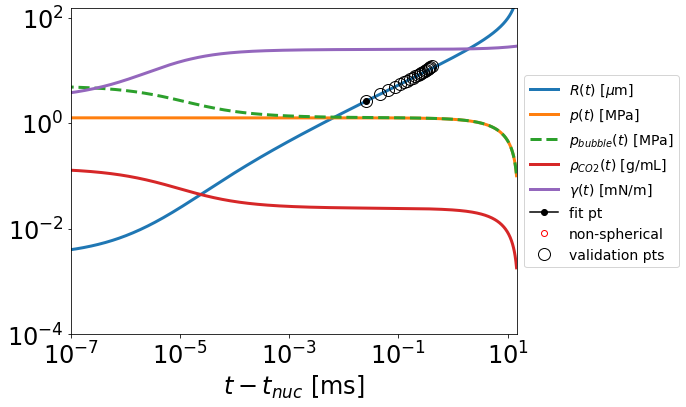

In [6]:
# log time axis
x_lim = [1E-7, 1.5E1]
y_lim = [0.0001, 150]
x_log = True
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, 
                    title='', ax=ax, austerity_level=1, lw=3, ax_fs=24, tk_fs=24)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles, R_bubbles[0], R_bubbles, t_R=(t, props_list_fit[0]),
                      non_sph_R=0.6*R_i, ms=12, color='k', fillstyle='none')
# ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)


## Fit Model to Data

In [7]:
# global constants for diffusion model
filepath_D_c='../g-adsa_results/D_c_power_law.csv'
df_D = pd.read_csv(filepath_D_c)
D0, A_p, k_p = df_D['p']

def D_p(c):
    """
    Power-law fit for D(c) fitted to *pressurization* data of 1k3f @ 30c
    (see 20201124_1k3f_D_vs_rho_co2.ipynb).
    """
    return D0 + A_p * c**k_p

# depressurization data-based model of diffusivity
D0, A_dp, k_dp = df_D['dp']

def D_dp(c):
    """
    Power-law fit for D(c) fitted to *depressurization* data of 1k3f @ 30c
    (see 20201124_1k3f_D_vs_rho_co2.ipynb).
    """
    return D0 + A_dp * c**k_dp

In [8]:
reload(diffn)
reload(bubble)
reload(bubbleflow)
reload(an)


def plot_pred(L, eps_params, D_fn, N, eta_ratio=1, R_bubble=-1):
    dt, p_s, R_nuc, _, p_in, v, polyol_data_file, eos_co2_file = eps_params
    eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

    # fits results to bubble growth model
    growth_fn = bubbleflow.sheath_incompressible
    i_t = 2 # index of t_bub in output of growth_fn
    i_R = 10 # index of R in output of growth_fn
    sigma_R = 0.03 # tolerance of error in radius
    # groups arguments for growth model
    D_max = D_fn(500) # [m^2/s]
    R_max = R_o
    dt_sheath = 0.5*(R_max/N)**2/D_max
    args = [eps_params, R_max, N, R_i, dt_sheath]
    dict_args = {'remesh_fn' : diffn.manage_grid_halving, 
                 'remesh_params' : {'pts_per_grad' : 5, 'interp_kind' : 'quadratic'}, 'D_fn' : D_fn,
                 'remesh_freq' : 100, 'alpha' : 0.3, 'eta_ratio' : eta_ratio} #, 't_f' : t_bubbles[-1]}
    ### TOLMAN LENGTH IS ESSENTIAL!!!
    i_t_nuc = 0

    # increases maximum iterations
    max_iter = 15

    # bounds on nucleation time
    t_nuc_lo = 0.05 # [s]
    t_nuc_hi = 0.0516 # [s]

    # opens figure to show results of different guesses for bubble nucleation time
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # radius of bubbles
    if R_bubble == -1:
        R_bubble = R_bubbles[0]

    # uses modified shooting method to estimate the nucleation time
    t_nuc, output = an.fit_growth_to_pt(t_bubble, R_bubble, t_nuc_lo, t_nuc_hi, growth_fn, args,
                         i_t_nuc, sigma_R=sigma_R, ax=ax, max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args)

    # unpacks output
    t_flow, c, t_bub, m, D, p, p_bub, if_tension, c_bub, c_bulk, R, \
                rho_co2, v, r_arr_data = output
    # prints pressure in stream upon nucleation of bubble
    print('p [Pa]', p[0])
    # groups results for plotting
    props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)
    
    c_s = [c_bulk] 

    # log time axis
    x_lim = [0.00000005, 25]
    y_lim = [0.001, 300]
    x_log = True
    title = 'Linear model for D(c) (pressurization curve)'
    ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubble, R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                          non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_s[0])
    pltg.legend(ax)

    # linear time axis
    x_lim = [0.0, 5]
    y_lim = [1, 50]
    x_log = False
    ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubble, R_bubbles[1:], non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_s[0])

    pltg.legend(ax)
    
    # plot concentration profile
    n_plot = 5

    ax = pltd.sheath_remesh(np.asarray(t_flow), r_arr_data, c, R_i, R_o, v, c_s[0], n_plot, t_nuc=t_nuc)
    ax.set_xscale('log')
    ax.set_xlim([1E-3, 150])
    pltg.legend(ax)
    
    return t_flow, t_bub, t_nuc, props_list_fit, t_bubbles, R_bubbles, r_arr_data, c, R_i, R_o, v, c_s[0]

### Plot Concentration In Inner Stream Over Time

0% complete, t = 0.000 ms.
10% complete, t = 14.581 ms.
20% complete, t = 29.162 ms.
30% complete, t = 43.742 ms.
regridding
mass in bubble decreased--density higher than bulk
rho_co2 814.3879668163331


StopIteration: 

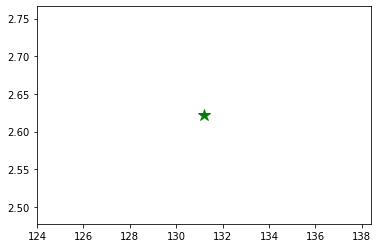

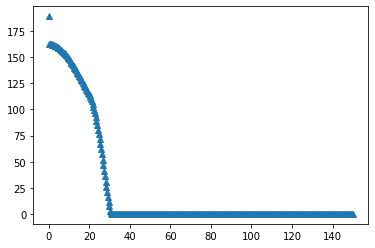

In [9]:
t_flow, t_bub, t_nuc, props_list_fit, t_bubbles, \
R_bubbles, r_arr_data, c, R_i, R_o, v, c_bulk = plot_pred(L, eps_params, D_p, 400, eta_ratio=330/4815, 
                                                          R_bubble=R_bubbles[0])

In [ ]:
i_r = 30
c_r = [c[i][i_r] for i in range(len(c))]

plt.plot(t_flow, c_r)

Why the kink at the end?

## Compare Effect of Length of Capillary (Proxy for Pressure at the End)

0% complete, t = 0.000 ms.
10% complete, t = 5.500 ms.
20% complete, t = 10.991 ms.
30% complete, t = 16.491 ms.
40% complete, t = 21.982 ms.
50% complete, t = 27.473 ms.
60% complete, t = 32.974 ms.
70% complete, t = 38.465 ms.
regridding
80% complete, t = 43.957 ms.
halving grid
halving grid
remeshed
90% complete, t = 49.478 ms.
0% complete, t = 0.000 ms.
10% complete, t = 5.500 ms.
20% complete, t = 10.991 ms.
30% complete, t = 16.491 ms.
40% complete, t = 21.982 ms.
50% complete, t = 27.473 ms.
60% complete, t = 32.974 ms.
70% complete, t = 38.465 ms.
regridding
80% complete, t = 43.959 ms.
halving grid
halving grid
remeshed
90% complete, t = 49.470 ms.
t_nuc = 41.700 ms and error in R is 0.8743.
0% complete, t = 0.000 ms.
10% complete, t = 5.500 ms.
20% complete, t = 10.991 ms.
30% complete, t = 16.491 ms.
40% complete, t = 21.982 ms.
50% complete, t = 27.473 ms.
60% complete, t = 32.974 ms.
70% complete, t = 38.465 ms.
regridding
80% complete, t = 43.961 ms.
halving grid
halving 

No handles with labels found to put in legend.


t_nuc = 42.869 ms and error in R is 0.0225.
Error in bubble radius is below tolerance of 0.0300 for nucleation time t = 42.869 ms
p [Pa] 2993888.9660346415
Model prediction at fit point is R = 4.039898 um.


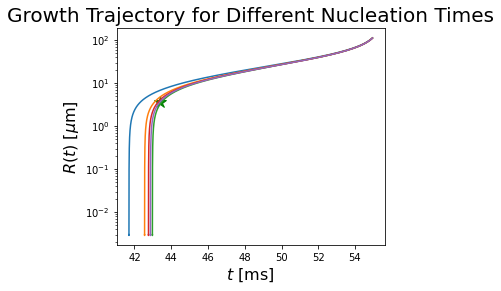

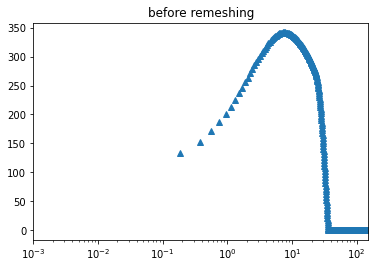

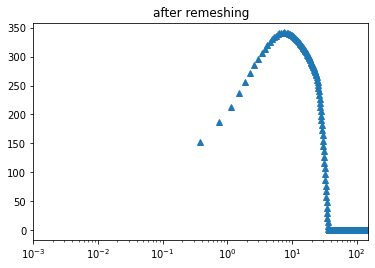

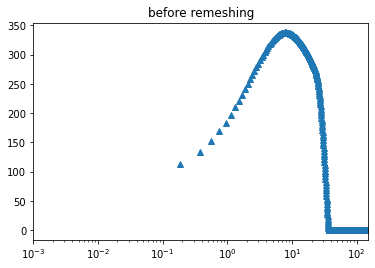

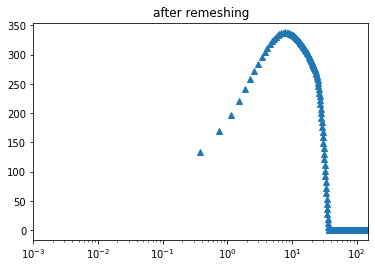

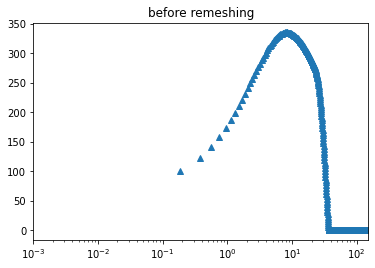

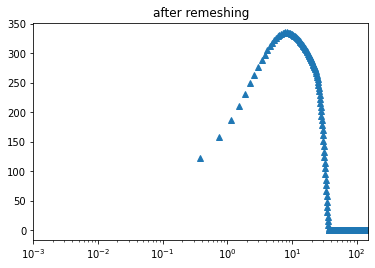

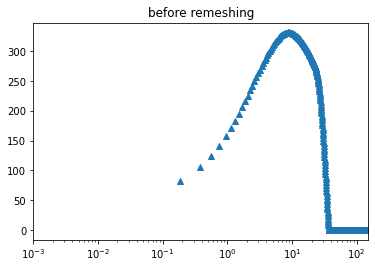

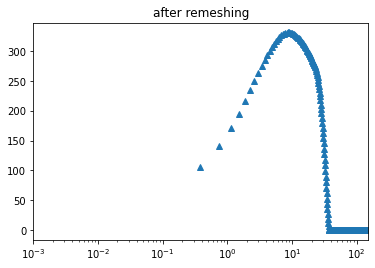

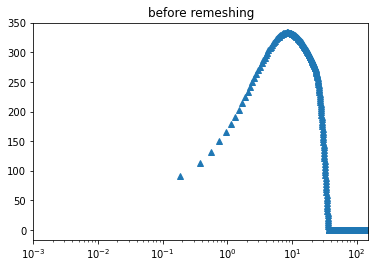

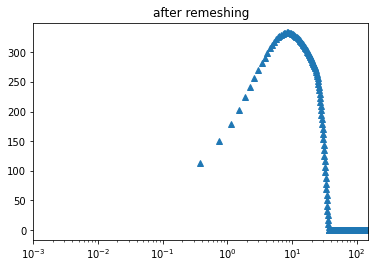

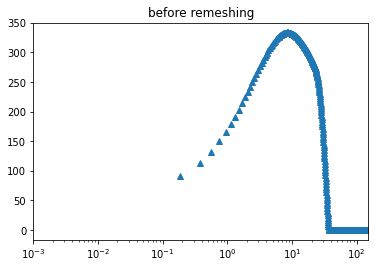

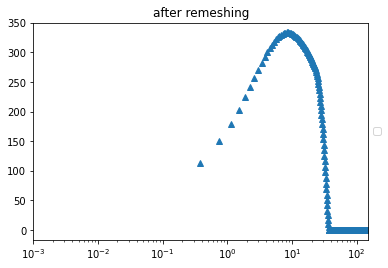

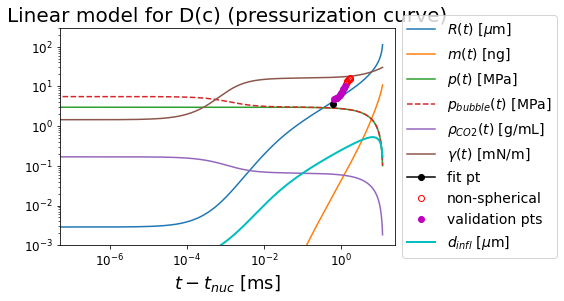

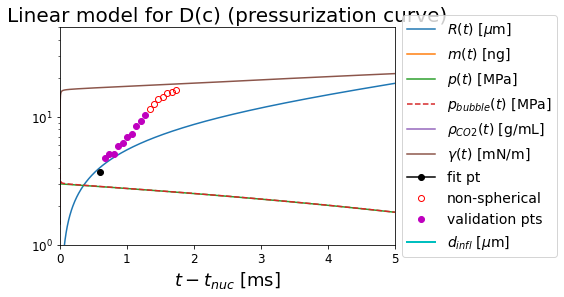

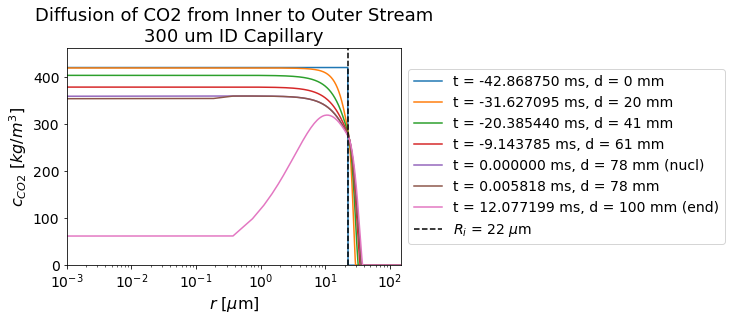

In [15]:
reload(diffn)
reload(bubbleflow)

t_flow, t_bub, t_nuc, props_list_fit, t_bubbles, \
R_bubbles, r_arr_data, c, R_i, R_o, v, c_bulk = plot_pred(L, eps_params, D_p, 800, eta_ratio=300/4815)

### Plot Results

Model prediction at fit point is R = 4.039898 um.


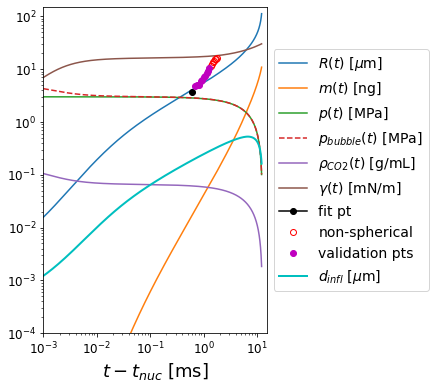

In [16]:
reload(pltb)
# log time axis
x_lim = [1E-3, 1.5E1]
y_lim = [0.0001, 150]
x_log = True
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                  non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)


Model prediction at fit point is R = 4.039898 um.


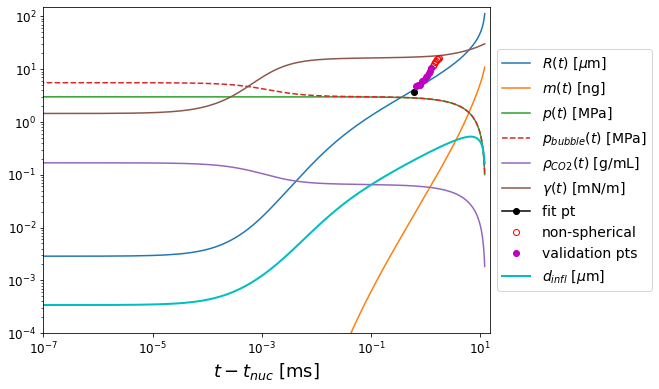

In [17]:
# log time axis
x_lim = [1E-7, 1.5E1]
y_lim = [0.0001, 150]
x_log = True
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                      non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)


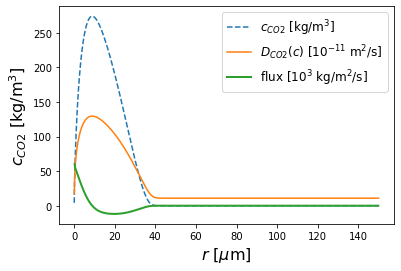

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111)

import finitediff as fd

r_arr = r_arr_data[0][-1]

dcdr_arr = fd.dydx_cd_2nd(np.asarray(c[-1]), r_arr[1] - r_arr[0])
D_arr = D_p(np.asarray(c[-1]))

ax.plot(r_arr*m_2_um, c[-1], '--', label=r'$c_{CO2}$ [kg/m$^3$]')
ax.plot(r_arr*m_2_um, 1E11*D_arr, label=r'$D_{CO2}(c)$ [$10^{-11}$ m$^2$/s]')
ax.plot(r_arr[1:-1]*m_2_um, D_arr[1:-1]*dcdr_arr*1000, lw=2, label=r'flux [$10^3$ kg/m$^2$/s]')


ax.set_xlabel(r'$r$ [$\mu$m]', fontsize=16)
ax.set_ylabel(r'$c_{CO2}$ [kg/m$^3$]', fontsize=16)
ax.legend(fontsize=12)

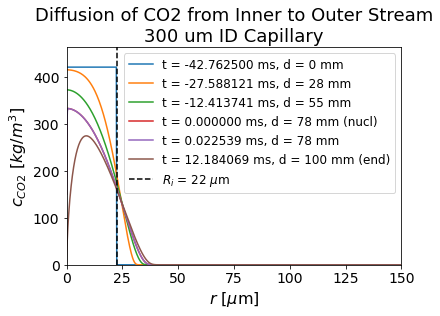

In [92]:
n_plot = 4
reload(pltd)
ax = pltd.sheath_remesh(np.asarray(t_flow), r_arr_data, c, R_i, R_o, v, c_bulk, n_plot, t_nuc=t_nuc)
# pltg.legend(ax)

0% complete, t = 0.000 ms.
10% complete, t = 5.221 ms.
20% complete, t = 10.440 ms.
30% complete, t = 15.661 ms.
40% complete, t = 20.880 ms.
50% complete, t = 26.099 ms.
60% complete, t = 31.320 ms.
70% complete, t = 36.539 ms.
halving grid
halving grid
80% complete, t = 41.762 ms.
90% complete, t = 46.981 ms.
0% complete, t = 0.000 ms.
10% complete, t = 5.221 ms.
20% complete, t = 10.440 ms.
30% complete, t = 15.661 ms.
40% complete, t = 20.880 ms.
50% complete, t = 26.099 ms.
60% complete, t = 31.320 ms.
70% complete, t = 36.539 ms.
80% complete, t = 41.759 ms.
halving grid
halving grid
90% complete, t = 46.981 ms.
t_nuc = 41.700 ms and error in R is 1.2611.
0% complete, t = 0.000 ms.
10% complete, t = 5.221 ms.
20% complete, t = 10.440 ms.
30% complete, t = 15.661 ms.
40% complete, t = 20.880 ms.
50% complete, t = 26.099 ms.
60% complete, t = 31.320 ms.
70% complete, t = 36.539 ms.
80% complete, t = 41.758 ms.
halving grid
halving grid
90% complete, t = 46.979 ms.
t_nuc = 42.550 ms

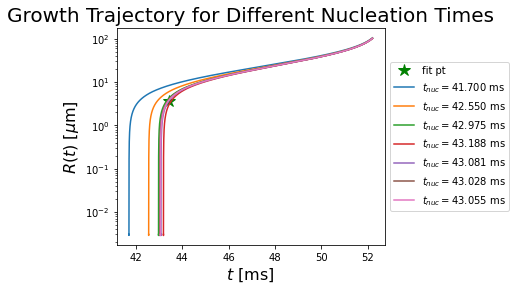

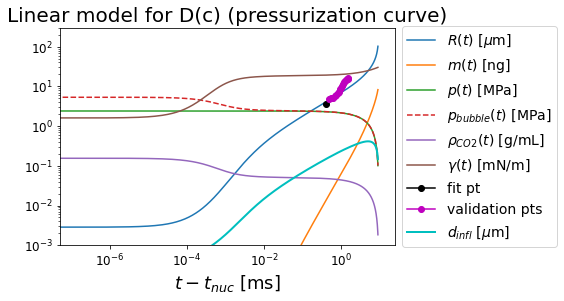

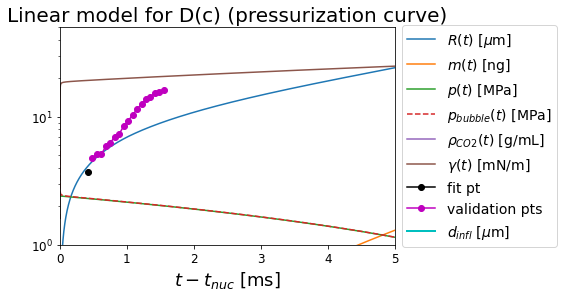

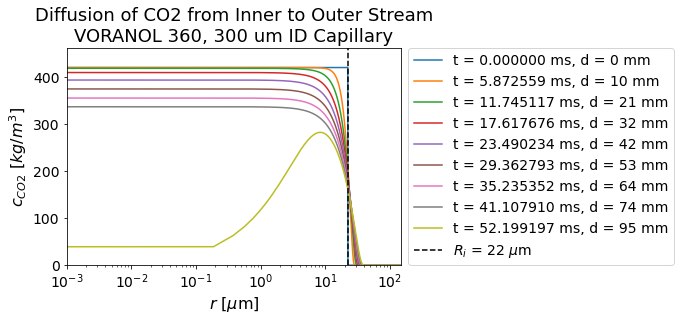

In [52]:
%%time

ax, c, r_arr = plot_pred(0.95*L, eps_params, D_p)

In [64]:
ax.set_xscale('linear')

TypeError: show() got an unexpected keyword argument 'axes'

### Consider Effect of Shorter Length

Plots diffusion profiles and predicted bubble growth for shorter capillary.

0% complete, t = 0.000 ms.
10% complete, t = 4.945 ms.
20% complete, t = 9.891 ms.
30% complete, t = 14.836 ms.
40% complete, t = 19.781 ms.
50% complete, t = 24.727 ms.
60% complete, t = 29.670 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.561 ms.
halving grid
halving grid
90% complete, t = 44.506 ms.
0% complete, t = 0.000 ms.
10% complete, t = 4.945 ms.
20% complete, t = 9.891 ms.
30% complete, t = 14.836 ms.
40% complete, t = 19.781 ms.
50% complete, t = 24.727 ms.
60% complete, t = 29.670 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.561 ms.
halving grid
halving grid
90% complete, t = 44.508 ms.
t_nuc = 41.700 ms and error in R is 2.0954.
0% complete, t = 0.000 ms.
10% complete, t = 4.945 ms.
20% complete, t = 9.891 ms.
30% complete, t = 14.836 ms.
40% complete, t = 19.781 ms.
50% complete, t = 24.727 ms.
60% complete, t = 29.670 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.561 ms.
halving grid
halving grid
90% complete, t = 44.511 ms.
t_nuc = 42.550 ms an

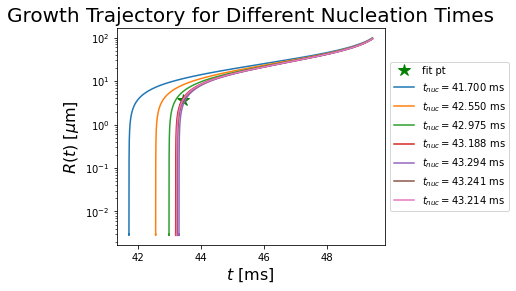

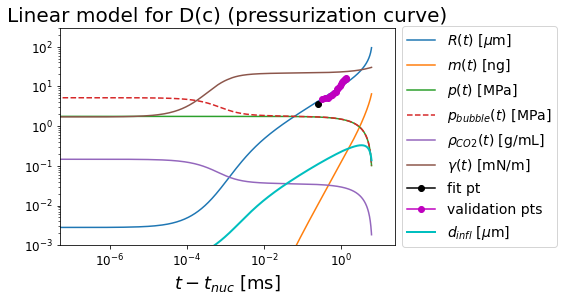

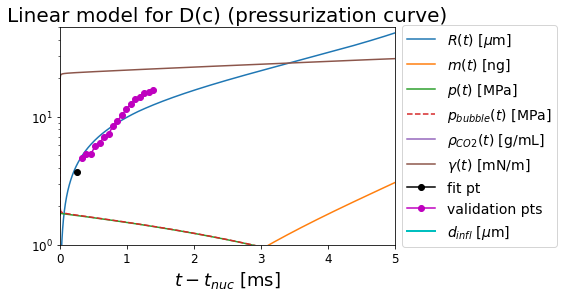

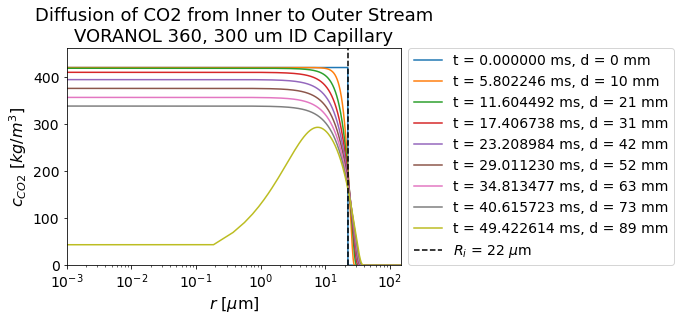

In [53]:
%%time 

ax, c, r_arr = plot_pred(0.9*L, eps_params, D_p)

#### Diffusivity Model Based on Depressurization

0% complete, t = 0.000 ms.
10% complete, t = 5.502 ms.
20% complete, t = 11.003 ms.
30% complete, t = 16.488 ms.
40% complete, t = 21.990 ms.
50% complete, t = 27.474 ms.
60% complete, t = 32.976 ms.
70% complete, t = 38.478 ms.
regridding
80% complete, t = 43.960 ms.
90% complete, t = 49.459 ms.
0% complete, t = 0.000 ms.
10% complete, t = 5.502 ms.
20% complete, t = 11.003 ms.
30% complete, t = 16.488 ms.
40% complete, t = 21.990 ms.
50% complete, t = 27.474 ms.
60% complete, t = 32.976 ms.
70% complete, t = 38.478 ms.
regridding
80% complete, t = 43.962 ms.
90% complete, t = 49.458 ms.
t_nuc = 41.700 ms and error in R is 0.9203.
0% complete, t = 0.000 ms.
10% complete, t = 5.502 ms.
20% complete, t = 11.003 ms.
30% complete, t = 16.488 ms.
40% complete, t = 21.990 ms.
50% complete, t = 27.474 ms.
60% complete, t = 32.976 ms.
70% complete, t = 38.478 ms.
regridding
80% complete, t = 43.963 ms.
90% complete, t = 49.453 ms.
t_nuc = 42.550 ms and error in R is 0.3377.
0% complete, t = 0

ValueError: too many values to unpack (expected 3)

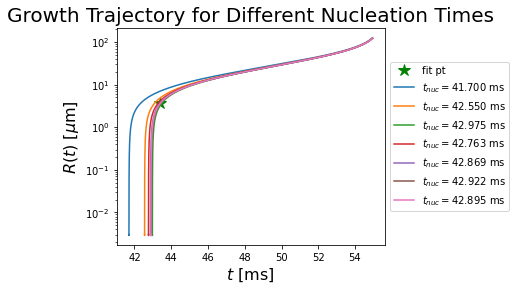

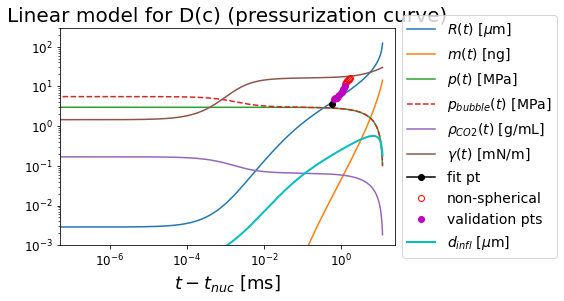

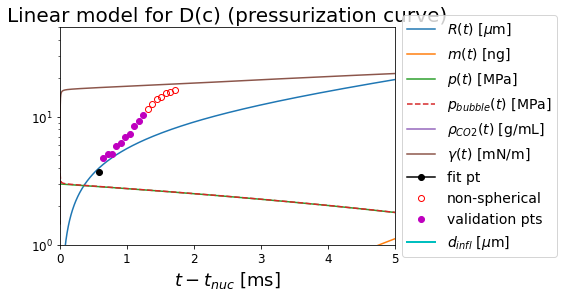

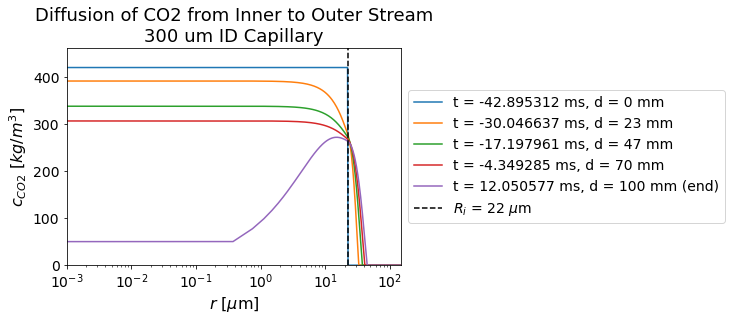

In [10]:
ax, c, r_arr = plot_pred(L, eps_params, D_dp, 400, eta_ratio=300/4815)

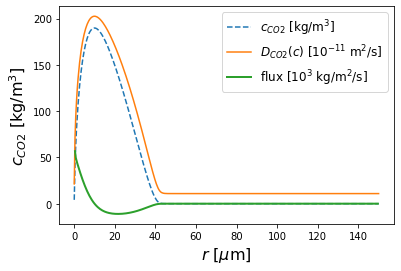

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)

import finitediff as fd

dcdr_arr = fd.dydx_cd_2nd(np.asarray(c), r_arr[1] - r_arr[0])
D_arr = D_dp(np.asarray(c))

ax.plot(r_arr*m_2_um, c, '--', label=r'$c_{CO2}$ [kg/m$^3$]')
ax.plot(r_arr*m_2_um, 1E11*D_arr, label=r'$D_{CO2}(c)$ [$10^{-11}$ m$^2$/s]')
ax.plot(r_arr[1:-1]*m_2_um, D_arr[1:-1]*dcdr_arr*1000, lw=2, label=r'flux [$10^3$ kg/m$^2$/s]')


ax.set_xlabel(r'$r$ [$\mu$m]', fontsize=16)
ax.set_ylabel(r'$c_{CO2}$ [kg/m$^3$]', fontsize=16)
ax.legend(fontsize=12)

0% complete, t = 0.000 ms.
10% complete, t = 5.228 ms.
20% complete, t = 10.457 ms.
30% complete, t = 15.668 ms.
40% complete, t = 20.896 ms.
50% complete, t = 26.107 ms.
60% complete, t = 31.336 ms.
70% complete, t = 36.547 ms.
80% complete, t = 41.768 ms.
90% complete, t = 46.986 ms.
0% complete, t = 0.000 ms.
10% complete, t = 5.228 ms.
20% complete, t = 10.457 ms.
30% complete, t = 15.668 ms.
40% complete, t = 20.896 ms.
50% complete, t = 26.107 ms.
60% complete, t = 31.336 ms.
70% complete, t = 36.547 ms.
80% complete, t = 41.759 ms.
90% complete, t = 46.990 ms.
t_nuc = 41.700 ms and error in R is 0.8027.
0% complete, t = 0.000 ms.
10% complete, t = 5.228 ms.
20% complete, t = 10.457 ms.
30% complete, t = 15.668 ms.
40% complete, t = 20.896 ms.
50% complete, t = 26.107 ms.
60% complete, t = 31.336 ms.
70% complete, t = 36.547 ms.
80% complete, t = 41.775 ms.
90% complete, t = 46.991 ms.
t_nuc = 42.550 ms and error in R is 0.2444.
0% complete, t = 0.000 ms.
10% complete, t = 5.228 

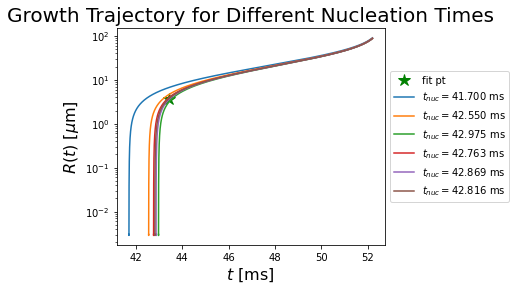

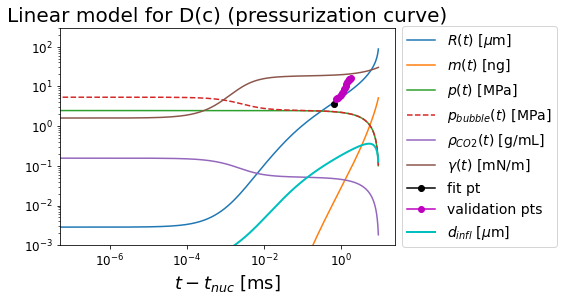

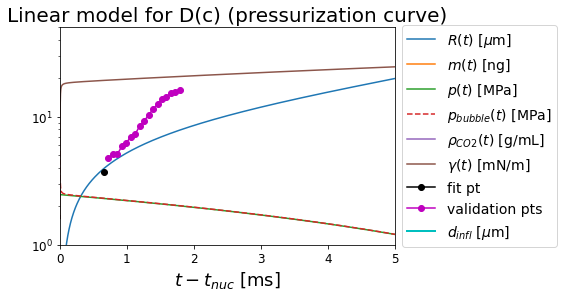

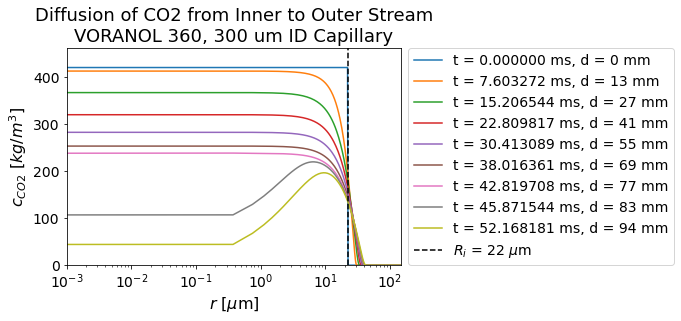

In [68]:
ax, c, r_arr = plot_pred(0.95*L, eps_params, D_dp, 400)

0% complete, t = 0.000 ms.
10% complete, t = 4.955 ms.
20% complete, t = 9.893 ms.
30% complete, t = 14.848 ms.
40% complete, t = 19.786 ms.
50% complete, t = 24.741 ms.
60% complete, t = 29.678 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.571 ms.
90% complete, t = 44.507 ms.
0% complete, t = 0.000 ms.
10% complete, t = 4.955 ms.
20% complete, t = 9.893 ms.
30% complete, t = 14.848 ms.
40% complete, t = 19.786 ms.
50% complete, t = 24.741 ms.
60% complete, t = 29.678 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.571 ms.
90% complete, t = 44.518 ms.
t_nuc = 41.700 ms and error in R is 1.5220.
0% complete, t = 0.000 ms.
10% complete, t = 4.955 ms.
20% complete, t = 9.893 ms.
30% complete, t = 14.848 ms.
40% complete, t = 19.786 ms.
50% complete, t = 24.741 ms.
60% complete, t = 29.678 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.571 ms.
90% complete, t = 44.506 ms.
t_nuc = 42.550 ms and error in R is 0.7270.
0% complete, t = 0.000 ms.
10% complete, t = 4.955 ms.

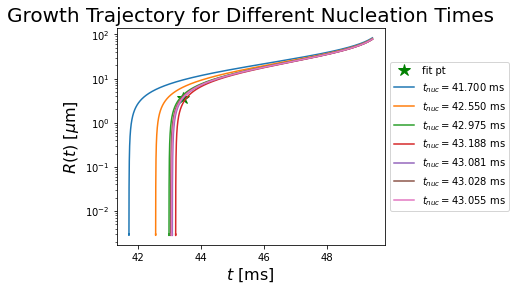

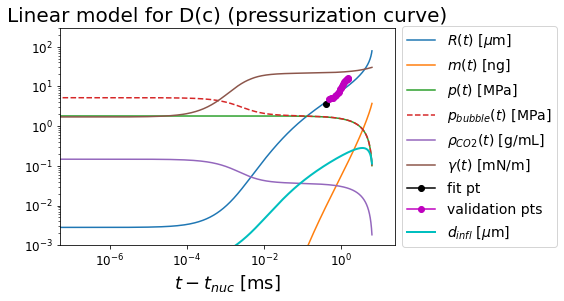

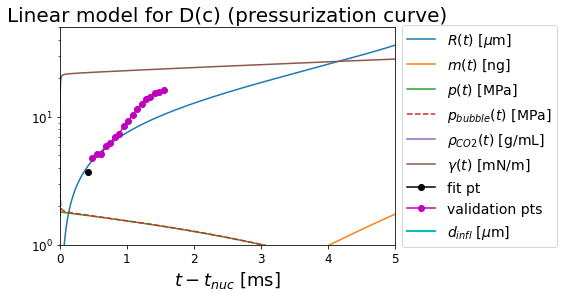

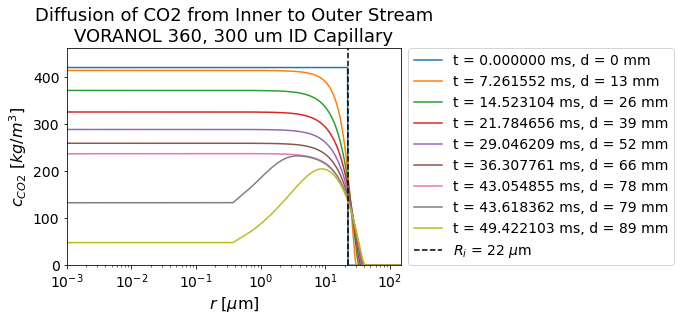

In [69]:
ax, c, r_arr = plot_pred(0.9*L, eps_params, D_dp, 400)

## Plot Sizes of All Bubbles Observed in Experiment

Comparison of bubble growth trajectories will show how many qualitatively different types of bubble growth were observed. We may be able to "stitch" together different trajectories if they appear to undergo the same behavior in the size ranges where they overlap.

In [51]:
import pickle as pkl

# loads parameters of experiment
data_filepath = '../bubble-tracking/data/sd301_co2/20210207_88bar/sd301_co2_15000_001_100_0335_79_100_04_10/' + \
                'std_full/f_7205_1_9232.pkl'
with open(data_filepath, 'rb') as f:
    data = pkl.load(f)
    
print(data.keys())
# computes flow parameters 
# defines diffusivity function
# loads data from bubble-tracking
# fits model to first data point
# plots results

dict_keys(['bubbles', 'frame IDs', 'metadata'])


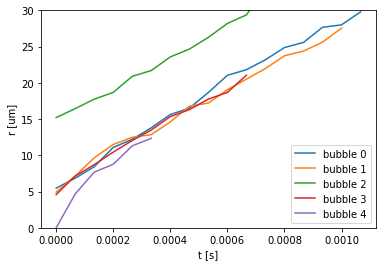

In [53]:
bubbles = data['bubbles']

fig = plt.figure()
ax = fig.add_subplot(111)


for key in bubbles:
    bubble = bubbles[key]
    on_border = bubble.get_props('on border')
    R_all = bubble.get_props('radius') # [um]
    R = [R_all[i]*1.34*2.29 for i in range(len(R_all)) if not on_border[i]]
    fps = bubble.get_metadata('fps')
    t = np.arange(len(R))/fps # [s]
    
    # plot
    ax.plot(t, R, label='bubble {0:d}'.format(bubble.get_metadata('ID')))
    
ax.set_xlabel('t [s]')
ax.set_ylabel('r [um]')
ax.set_ylim([0, 30])
ax.legend()


## Plot Length of Elongated Bubbles

In [29]:
def plot_length_vs_time(t, w, loglog=False, ax_fs=18, t_fs=20, lw=2, tk_fs=16):
    # creates figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # plots data
    ax.plot(t, w, '^', lw=lw)
    # formats plot
    ax.set_xlabel(r'time [$\mu$s]', fontsize=ax_fs)
    ax.set_ylabel(r'head-to-tail distance [$\mu$m]', fontsize=ax_fs)
    ax.set_title('Length of Bubble vs. Time', fontsize=t_fs)
    ax.tick_params(axis='both', labelsize=tk_fs)
    # plot on log-log axes?
    if loglog:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    return ax

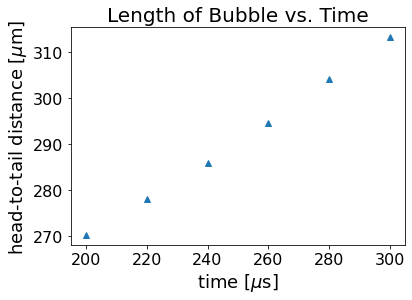

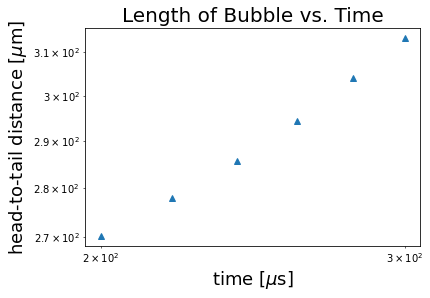

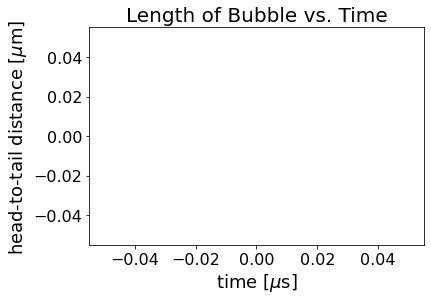

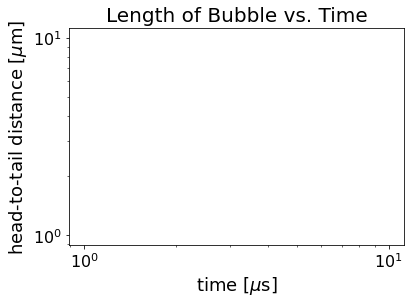

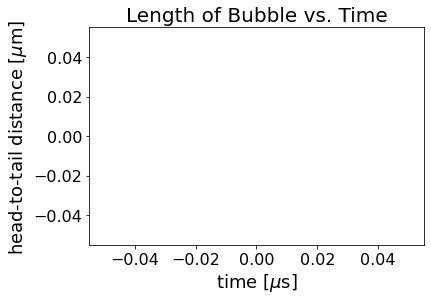

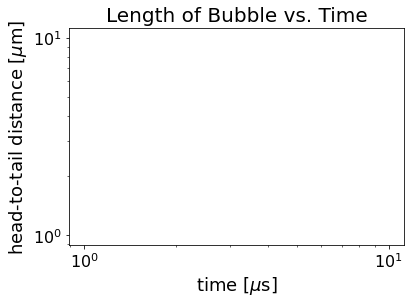

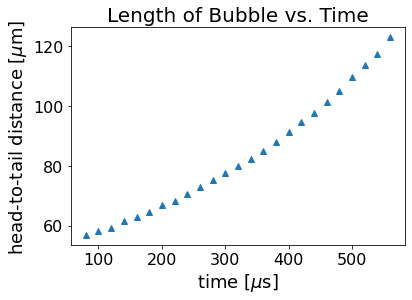

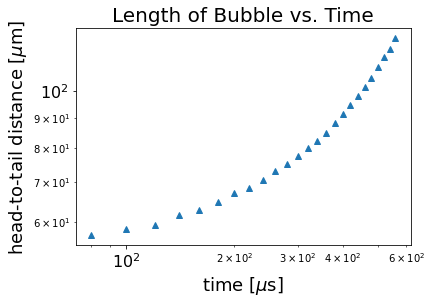

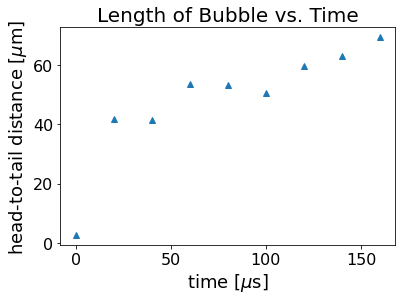

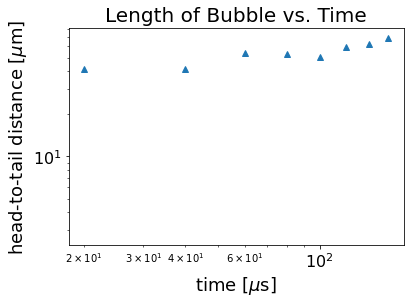

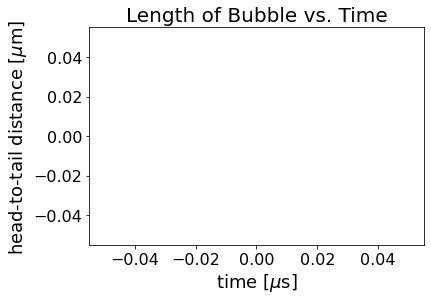

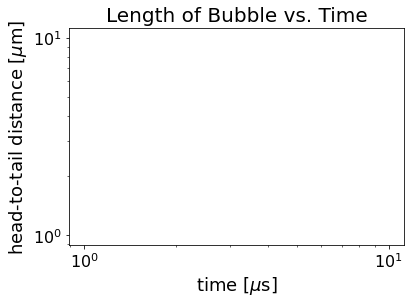

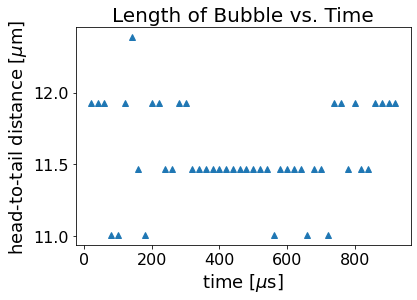

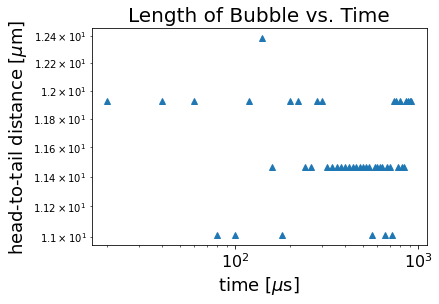

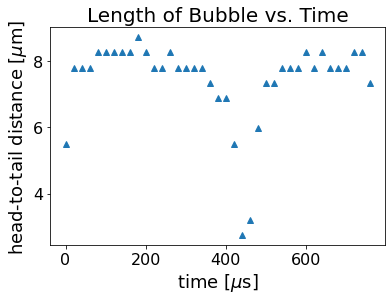

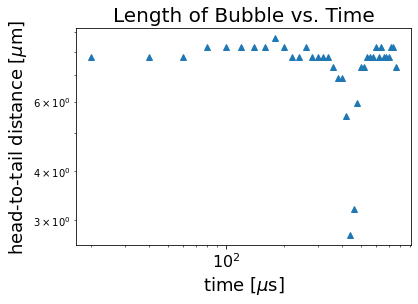

In [31]:
### Identifies bubbles that become elongated ###

# parameters
min_aspect_ratio = 2 # elongated bubbles must have minimum aspect ratio
min_frames = 5 # elongated bubbles are only interesting if we observe multiple frames

# initializes list of indices of elongated bubbles
inds_elong = []
for i in range(len(data['objects'])):
    # computes maximum height and width of each object observed
    bbox_list = data['objects'][i]['props_raw']['bbox']
    h_max = np.max([r_hi - r_lo for r_lo, _, r_hi, _ in bbox_list]) 
    w_max = np.max([c_hi - c_lo for _, c_lo, _, c_hi in bbox_list])
    
    # considers bubbles elongated if the width:height ratio is
    # greater than the minimum aspect ratio specified 
    if (w_max / h_max > min_aspect_ratio) and (len(bbox_list) > min_frames):
        inds_elong += [i]

# extracts length of each bubble
for i in inds_elong:
    bub = data['objects'][i]
    # computes width [um]
    bbox_list = bub['props_raw']['bbox']
    pix_per_um = data['metadata']['object_kwargs']['pix_per_um']
    w_list = [(c_hi - c_lo)/pix_per_um for _, c_lo, _, c_hi in bbox_list]
    # computes time [us]
    n_frames = len(bbox_list)
    t_arr = np.arange(n_frames)/fps*s_2_us
    
    # identifies valid windows where bubble is not on border
    idx_valid = np.logical_not(bub['props_raw']['on border'])
    
    # formats arrays for plotting
    t_arr = t_arr[idx_valid]
    w_arr = np.array(w_list)[idx_valid]
    
    # plots length vs time
    plot_length_vs_time(t_arr, w_arr, loglog=False)
    plot_length_vs_time(t_arr, w_arr, loglog=True)